This notebooks aims to 

1. plot the relationship between f_effNO2 and Cloud Pressure
2. plot the contribution of SCD and VCD to the AMF changes

Three regions are defined:

- fresh lightning region: MT $\Delta$AMF$_{Trop}$ < 20 %
- Downwind of fresh lightning region: MT $\Delta$AMF$_{Trop}$ > 20%
- Aged lightning: UT $\Delta$AMF$_{Trop}$ > 20%

In [1]:
import xarray as xr
import numpy as np
from glob import glob
import proplot as plot

In [2]:
ds_2019 = xr.open_dataset(glob('../data/s5p_chem/tm5/S5P_TM5_L2__NO2____20190725*')[0], group='S5P')
ds_2020 = xr.open_dataset(glob('../data/s5p_chem/tm5/S5P_TM5_L2__NO2____20200901*')[0], group='S5P')

ds_lnox_2019 = xr.open_dataset(glob('../data/s5p_chem/lnox_500/S5P_CHEM_L2__NO2____20190725*')[0], group='CHEM')
ds_nolnox_2019 = xr.open_dataset(glob('../data/s5p_chem/nolnox/S5P_CHEM_L2__NO2____20190725*')[0], group='CHEM')
ds_lnox_2020 = xr.open_dataset(glob('../data/s5p_chem/lnox_500/S5P_CHEM_L2__NO2____20200901*')[0], group='CHEM')
ds_nolnox_2020 = xr.open_dataset(glob('../data/s5p_chem/nolnox/S5P_CHEM_L2__NO2____20200901*')[0], group='CHEM')

In [3]:
topest_pressure_2019 = xr.DataArray(np.full((1, ds_lnox_2019.sizes['y'], ds_lnox_2019.sizes['x']), 0),
                                    dims=['plevel', 'y', 'x'])
topest_pressure_2020 = xr.DataArray(np.full((1, ds_lnox_2020.sizes['y'], ds_lnox_2020.sizes['x']), 0),
                                    dims=['plevel', 'y', 'x'])

s5p_p_2019 = xr.concat([ds_lnox_2019['plevels'], topest_pressure_2019], dim='plevel')
s5p_p_2020 = xr.concat([ds_lnox_2020['plevels'], topest_pressure_2020], dim='plevel')

In [4]:
def integPr(no2, s5p_p, psfc, ptropo):
    layername = no2.dims[0]

    # constants
    R = 287.3
    T0 = 273.15
    g0 = 9.80665
    p0 = 1.01325e5


    subcolumn = 10 * R *T0 /(g0*p0) \
              * no2*1e6 \
              * abs(s5p_p.diff(s5p_p.dims[0])) * 2.6867e16 # DU to moleclues/cm2
        
    sub_layer = (s5p_p <= psfc) & (s5p_p > ptropo)

    vcd = subcolumn.where(sub_layer[:-1, ...].values).sum(layername)

    return vcd

In [5]:
def cal_amf(ds, ds_lnox, da_mod, s5p_p):
    scdClr = integPr(da_mod * ds_lnox['swClr'],
                     s5p_p,
                     ds['surface_pressure']/1e2, ds_lnox['tropopause_pressure'])

    scdCld = integPr(da_mod * ds_lnox['swCld'],
                     s5p_p,
                     ds['cloud_pressure_crb']/1e2, ds_lnox['tropopause_pressure'])

    vcdGnd = integPr(da_mod, s5p_p, ds['surface_pressure']/1e2, ds_lnox['tropopause_pressure'])

    amfClr = scdClr / vcdGnd
    amfCld = scdCld / vcdGnd

    crf = ds['cloud_radiance_fraction_nitrogendioxide_window']

    amf = amfClr*(1-crf) + amfCld*crf
    scd = scdClr*(1-crf) + scdCld*crf

    return amf, scd, vcdGnd

In [6]:
def new_amf(ds, ds_nolnox, ds_lnox, s5p_p, p_min=None, p_max=None, cmap='RdBu_r', cut=0):
    '''
    Replace the a priori profile, recalculate AMF, and
        calculate the percent difference:
            (new_AMF - AMF_nolnox) / AMF_nolnox, units: %

    Finally, plot the percent difference on ax.
    
    Return the plot object.
    '''

    if p_min and p_max:
        p = (p_min <= ds_lnox['plevels']) & (ds_lnox['plevels'] <= p_max)
    elif p_min:
        p = ds_lnox['plevels'] < p_min
    elif p_max:
        p = ds_lnox['plevels'] > p_max
    else:
        p = xr.full_like(ds_lnox['plevels'], True, dtype='bool')

    scd = ds_nolnox['scdClr']*(1-ds['cloud_radiance_fraction_nitrogendioxide_window'])+ds_nolnox['scdCld']*ds['cloud_radiance_fraction_nitrogendioxide_window']
    vcd = ds_nolnox['vcdGnd']

    da_mod = ds_nolnox['no2apriori'].where(~p, ds_lnox['no2apriori'])
    amf_mod, scd_mod, vcd_mod = cal_amf(ds, ds_lnox, da_mod, s5p_p)
    amf = ds_nolnox['amfTrop']
    # difference = (amf_mod-amf)/amf*1e2

    return amf, amf_mod, scd_mod, vcd_mod, scd, vcd

In [7]:
def def_subset(ds, extend):
    subset = (extend[0] <= ds.coords['longitude'].isel(time=0)) \
            & (ds.coords['longitude'].isel(time=0) <= extend[1]) \
            & (extend[2] <= ds.coords['latitude'].isel(time=0)) \
            & (ds.coords['latitude'].isel(time=0) <= extend[3])

    return subset

def calc_subset(ds, ds_lnox, ds_nolnox, s5p_p, subset, pmin=None, p_max=None, vmin=None, vmax=None):
    amf, amf_new, _, _, _, _ = new_amf(ds, ds_nolnox, ds_lnox, s5p_p, p_min=400, p_max=800)
    _, _, scd_new, vcd_new, scd, vcd = new_amf(ds, ds_nolnox, ds_lnox, s5p_p)
    pdiff = ((amf_new-amf)/amf).where(subset)

    if vmin:
        pdiff = pdiff.stack(dim0=['x', 'y'])>vmin
    elif vmax:
        pdiff = pdiff.stack(dim0=['x', 'y'])<vmax

    cp = ds['cloud_pressure_crb'].where(subset).stack(dim0=['x', 'y']).where(pdiff, drop=True)
    crf = ds['cloud_fraction_crb_nitrogendioxide_window'].where(subset).stack(dim0=['x', 'y']).where(pdiff, drop=True)
    scd_new = scd_new.where(subset).stack(dim0=['x', 'y']).where(pdiff, drop=True)
    vcd_new = vcd_new.where(subset).stack(dim0=['x', 'y']).where(pdiff, drop=True)
    scd = scd.where(subset).stack(dim0=['x', 'y']).where(pdiff, drop=True)
    vcd = vcd.where(subset).stack(dim0=['x', 'y']).where(pdiff, drop=True)

    return crf, cp, scd_new, vcd_new, scd, vcd

In [8]:
extend_2019 = [118, 119.6, 31.2, 32.8]
extend_2020 = [118.1, 119.7, 30.5, 32.05]

subset_2019 = def_subset(ds_2019, extend_2019)
subset_2020 = def_subset(ds_2020, extend_2020)

# aged: UT > 20%
crf_aged, cp_aged, scd_aged_lnox, vcd_aged_lnox,\
scd_aged_nolnox, vcd_aged_nolnox = calc_subset(ds_2020, ds_lnox_2020, ds_nolnox_2020,
                                                         s5p_p_2020, subset_2020,
                                                         pmin=150, p_max=400, vmin=0.2)

# fresh: MT < -20%
crf_fresh, cp_fresh, scd_fresh_lnox, vcd_fresh_lnox, \
scd_fresh_nolnox, vcd_fresh_nolnox = calc_subset(ds_2019, ds_lnox_2019, ds_nolnox_2019,
                                                   s5p_p_2019, subset_2019,
                                                   pmin=400, p_max=800, vmax=-0.2)

# downwind: MT > 20%
crf_downwind, cp_downwind, scd_downwind_lnox, vcd_downwind_lnox, \
scd_downwind_nolnox, vcd_downwind_nolnox = calc_subset(ds_2019, ds_lnox_2019, ds_nolnox_2019,
                                                       s5p_p_2019, subset_2019,
                                                       pmin=400, p_max=800, vmin=0.2)

In [9]:
def plot_ratio(x, scd_lnox, scd_nolnox, vcd_lnox, vcd_nolnox, c, title):
    l_scd = ax.plot(x, scd_lnox/scd_nolnox, c=c, label='SCD$^{LNO_x}_{tropNO_2}$/SCD$^{noLNO_x}_{tropNO_2}$')
    l_vcd = ax.plot(x, vcd_lnox/vcd_nolnox, c=c, linestyle='--', label='VCD$^{LNO_x}_{tropNO_2}$/VCD$^{noLNO_x}_{tropNO_2}$')
    ax.legend([l_scd, l_vcd], loc='ul', labelspacing=1.5)
    ax.format(title=title)

/tmp/ipykernel_36196/392512813.py:1: ProplotWarning: The rc setting 'text.labelsize' was deprecated in version 0.8.0 and may be removed in the first major release (version 1.0.0). Please use 'font.smallsize' instead.
  with plot.rc.context({'text.labelsize': 12, 'titlesize': 14}):
/tmp/ipykernel_36196/392512813.py:57: ProplotWarning: The rc setting 'abc.style' was deprecated in version 0.8.0 and may be removed in the first major release (version 1.0.0). Please use 'abc' instead.
  axs.format(grid=False,
/tmp/ipykernel_36196/392512813.py:57: ProplotWarning: The rc setting 'abc.style' was deprecated in version 0.8.0 and may be removed in the first major release (version 1.0.0). Please use 'abc' instead.
  axs.format(grid=False,
/tmp/ipykernel_36196/392512813.py:57: ProplotWarning: The rc setting 'abc.style' was deprecated in version 0.8.0 and may be removed in the first major release (version 1.0.0). Please use 'abc' instead.
  axs.format(grid=False,
/tmp/ipykernel_36196/392512813.py:57:

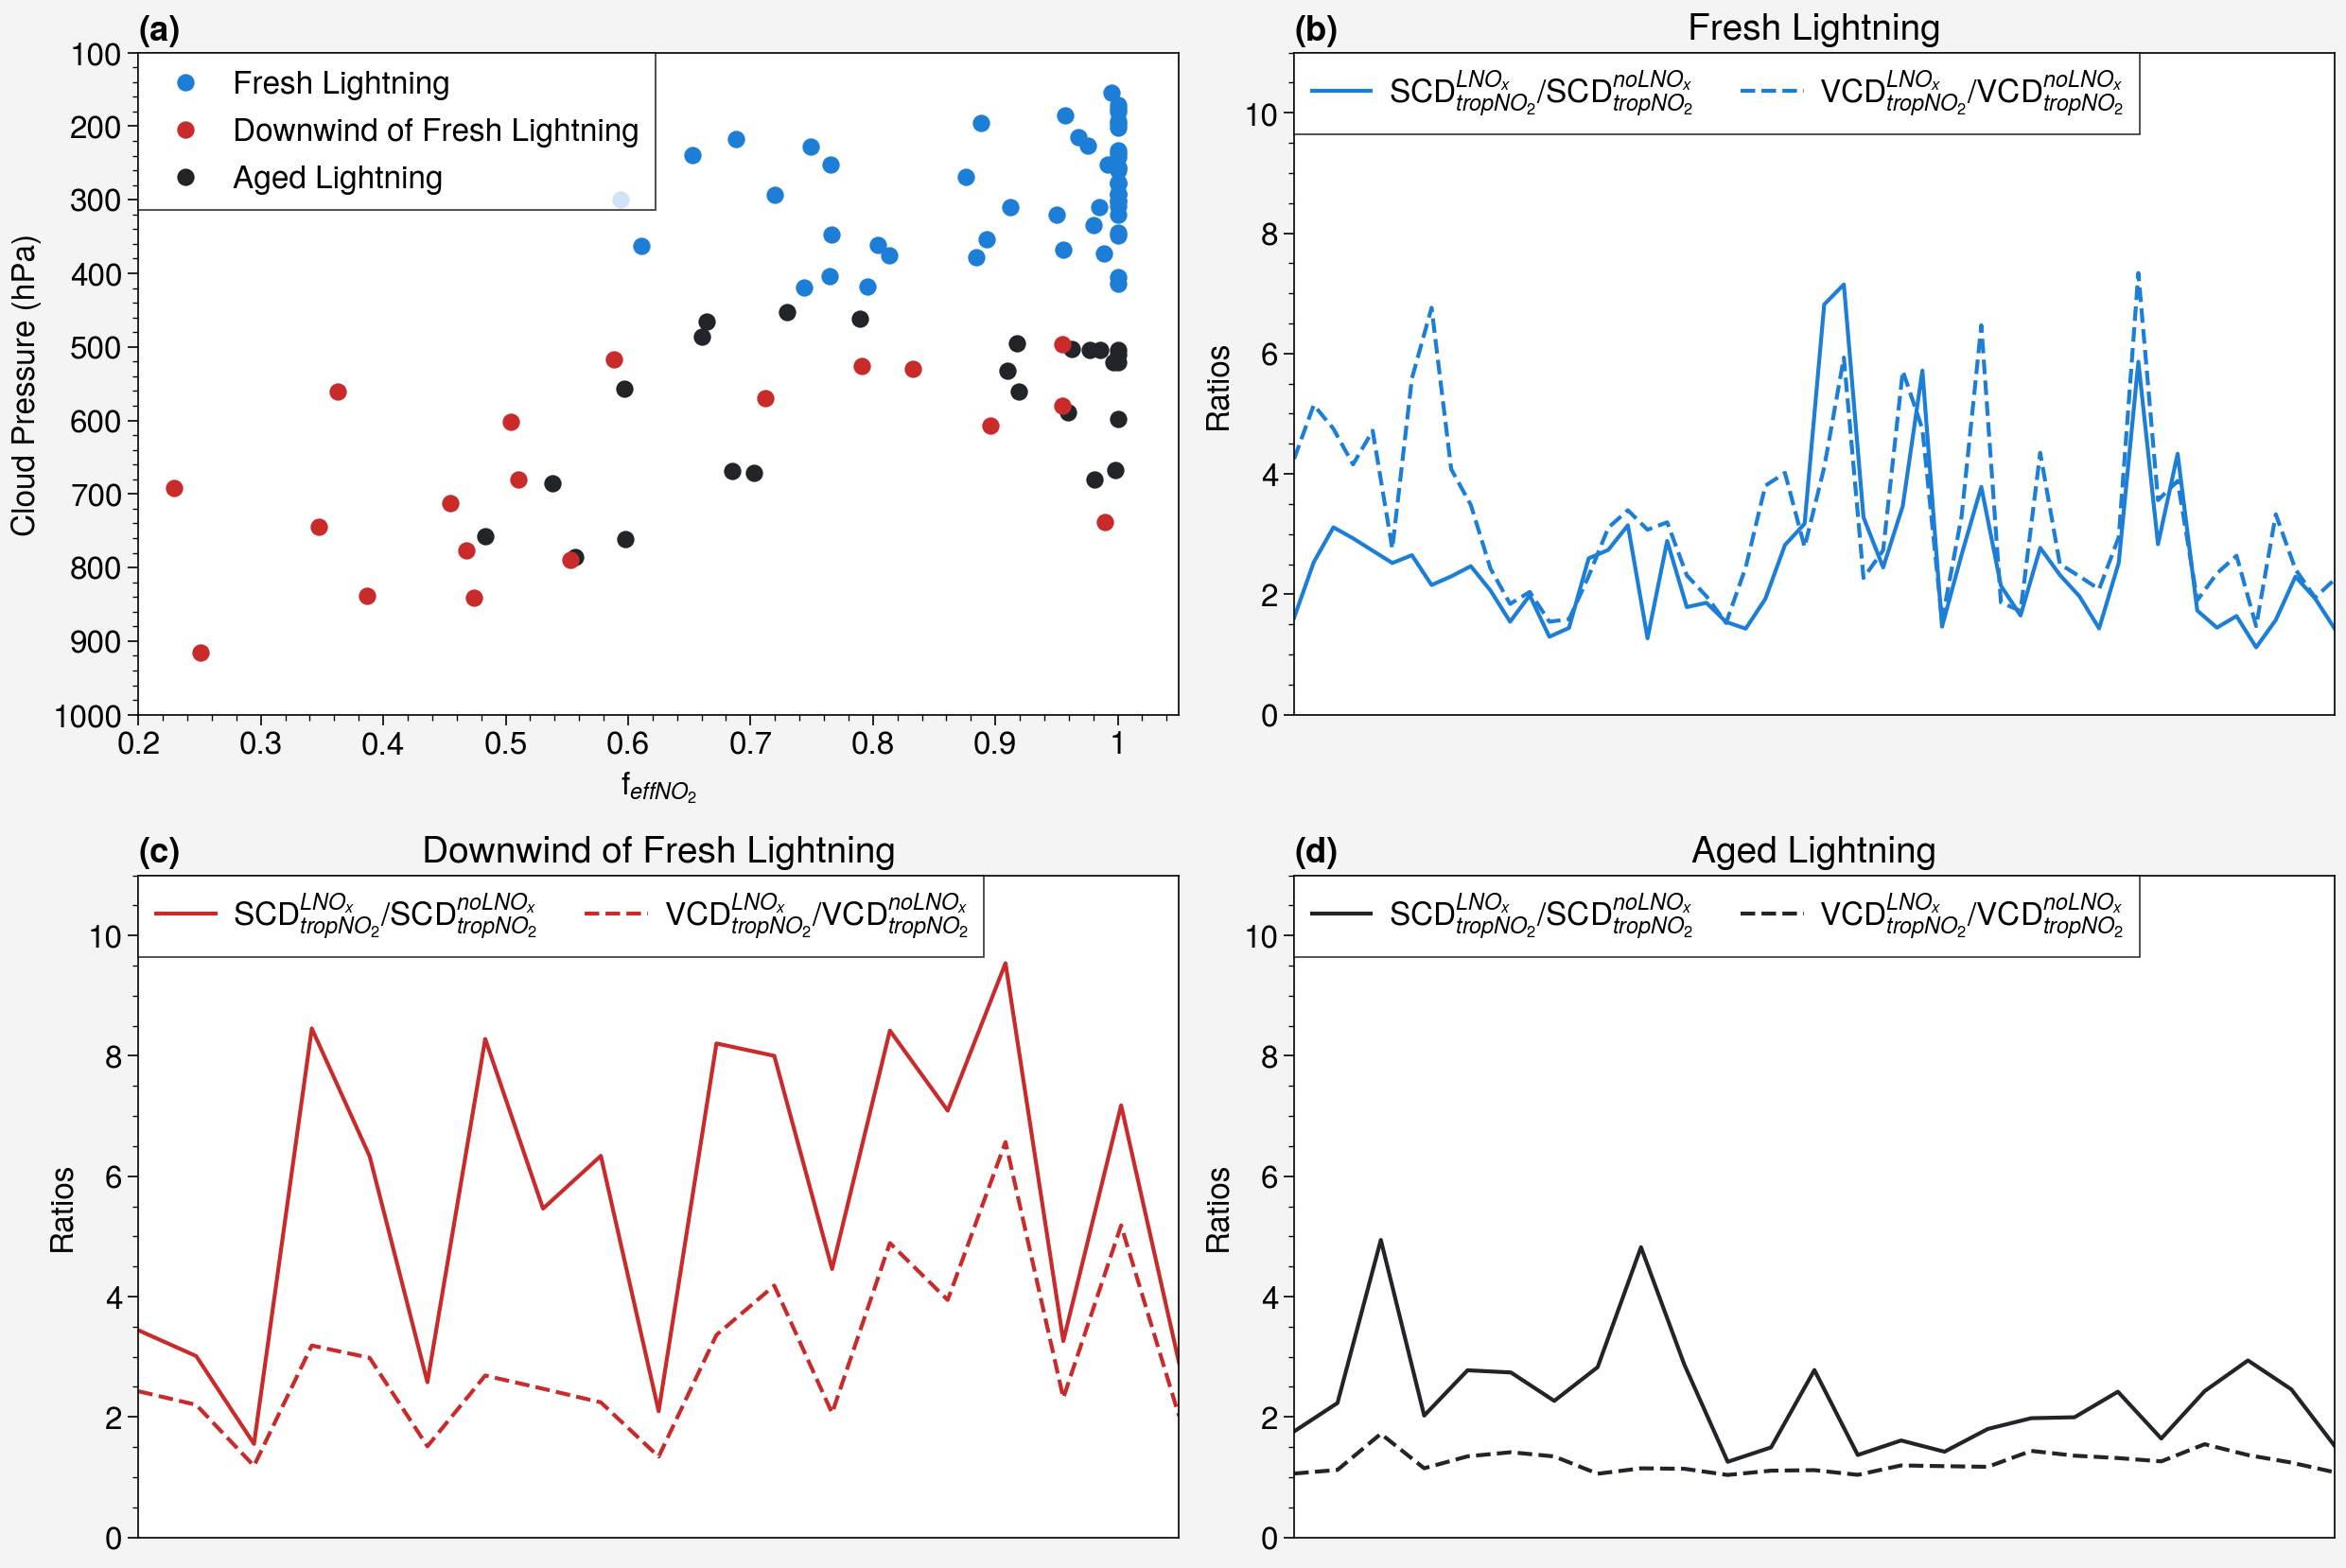

In [10]:
with plot.rc.context({'text.labelsize': 12, 'titlesize': 14}):
    fig, axs = plot.subplots(ncols=2, nrows=2, share=0, refwidth=5.5, refheight=3.5)

    x_fresh = np.linspace(0, 1, len(scd_fresh_lnox))
    x_downwind = np.linspace(0, 1, len(scd_downwind_lnox))
    x_aged = np.linspace(0, 1, len(scd_aged_lnox))

    c_fresh = 'blue7'
    c_aged = 'gray9'
    c_downwind = 'red9'

    label_fresh = 'Fresh Lightning'
    label_aged = 'Aged Lightning'
    label_downwind = 'Downwind of Fresh Lightning'

    # --- subplot 1 ---
    ax = axs[0]
    s_fresh = ax.scatter(crf_fresh, cp_fresh/1e2, c=c_fresh,
                          label=label_fresh)

    s_aged = ax.scatter(crf_aged, cp_aged/1e2, c=c_aged,
                             label=label_aged)

    s_downwind = ax.scatter(crf_downwind, cp_downwind/1e2, c=c_downwind,
                            label=label_downwind)

    ax.legend([s_fresh, s_downwind, s_aged], loc='ul', ncols=1)
    ax.format(ylabel='Cloud Pressure (hPa)',
              xlabel='f$_{effNO_2}$',
              xlim=(0.2, 1.05),
              ylim=(1000, 100)
             )

    # --- subplot 2 ---
    # fresh
    ax = axs[1]
    plot_ratio(x_fresh, scd_fresh_lnox, scd_fresh_nolnox,
               vcd_fresh_lnox, vcd_fresh_nolnox, c_fresh,
               label_fresh)

    # --- subplot 3 ---
    # downwind
    ax = axs[2]
    plot_ratio(x_downwind, scd_downwind_lnox, scd_downwind_nolnox,
               vcd_downwind_lnox, vcd_downwind_nolnox, c_downwind,
               label_downwind)

    # --- subplot 4 ---
    # aged
    ax = axs[3]
    plot_ratio(x_aged, scd_aged_lnox, scd_aged_nolnox,
               vcd_aged_lnox, vcd_aged_nolnox, c_aged,
               label_aged)

    axs[1:].format(ylim=(0, 11), ylabel='Ratios', xlabel='', xticks='none')

    axs.format(grid=False,
               abc=True,
               abcloc='l',
               abcstyle='(a)',
               abcsize=13,
              )

    fig.savefig('../figures/amf_contribution.pdf')